<a href="https://colab.research.google.com/github/zackives/upenn-cis5450-hw/blob/main/Module_1_Data_Acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Part I of Big Data Analytics

As we start our journey into Big Data Analytics, the first thing we need to do is **get the data** in the form we need for analysis!  We'll start with an overview of how to acquire and *wrangle* data.

This notebook will be built incrementally to consider several tasks:

* Acquiring data from files and remote sources
* Information extraction over HTML content
* A basic "vocabulary" of operators over tables (the relational algebra)
* Basic manipulation using SQL in DuckDB

* "Data wrangling" or integration:
  * Cleaning and filtering data, using rules and based operations
  * Linking data across dataframes or relations
  * The need for approximate match and record linking
  * Different techniques


## The Motivating Question
To illustrate the principles, we focus on the question of **how old company CEOs and founders** (in general, leaders) are.  The question was in part motivated by the following New York Times article:

* Founders of Successful Tech Companies Are Mostly Middle-Aged: https://www.nytimes.com/2019/08/29/business/tech-start-up-founders-nest.html?searchResultPosition=2

So let's test this hypothesis!

## Initial Libraries

We'll be using [DuckDB](https://duckdb.org/) as a means of managing our tables.  DuckDB works like a Python library, but manages a full SQL database (in files).  It also integrates very nicely with Pandas, so we'll use it in this course.

In [1]:
!pip3 install duckdb

In [2]:
!pip3 install lxml

In [3]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [4]:
!pip3 install penngrader-client

For quiz credit you'll need to update your student ID here!

In [5]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 99999999 # YOUR PENN-ID GOES HERE AS AN INTEGER##PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO

Quizzes will cumulatively count as HW9... Don't edit this...

In [6]:
%set_env HW_ID=cis5450_25f_HW9

env: HW_ID=cis5450_25f_HW9


In [7]:
import os
from penngrader.grader import *

grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 99999999

Make sure this correct or we will not be able to store your grade


In [8]:
# Imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib
import urllib.request

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import duckdb

# Data visualization
import matplotlib



# 1. Acquiring External Data

To test our hypothesis, we might want:

1. A list of companies (and, for futher details, perhaps their lines of business)
2. A list of company CEOs
3. Ages of the CEOs

We'll go through each of these using real data from the web.

### Reading Structured Data Sources

Let's start by looking up data about companies.  We are using a dataset from: https://www.kaggle.com/datasets/peopledatalabssf/free-7-million-company-dataset?resource=download

but we have a copy of it at an alternate site for convenience of downloading.

## 1.1. External CSV Data

Comma-separated values are generally easy to read. The main questions are column headings (which are in an optional row that isn't always provided) and datatypes (which might default to the wrong thing).

In [9]:
!wget -nc https://storage.googleapis.com/penn-cis5450/companies_sorted.csv

--2025-09-02 17:22:15--  https://storage.googleapis.com/penn-cis5450/companies_sorted.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1085578742 (1.0G) [text/csv]
Saving to: ‘companies_sorted.csv’

companies_sorted.cs 100%[===================>]   1.01G  92.7MB/s    in 11s     

2025-09-02 17:22:26 (93.4 MB/s) - ‘companies_sorted.csv’ saved [1085578742/1085578742]



In [10]:
# This reads remotely. To avoid multiple fetches, we'll instead..

# data = urllib.request.urlopen(\
#        'https://storage.googleapis.com/penn-cis5450/companies_sorted.csv')
# company_data_df = pd.read_csv(data)

## ... instead copy to a local file and read there...

company_data_df = pd.read_csv('companies_sorted.csv')

company_data_df

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960
...,...,...,...,...,...,...,...,...,...,...,...
7173421,1494427,certiport vouchers,certiportvouchers.com,2011.0,information technology and services,1 - 10,NaN,NaN,linkedin.com/company/certiport-vouchers,0,1
7173422,1494429,black tiger fight club,blacktigerclub.com,2006.0,"health, wellness and fitness",1 - 10,"peking, beijing, china",china,linkedin.com/company/black-tiger-club-hero,0,6
7173423,4768462,catholic bishop of chicago,NaN,NaN,religious institutions,1 - 10,"inverness, illinois, united states",united states,linkedin.com/company/catholic-bishop-of-chicago,0,1
7173424,1494436,medexo robotics ltd,NaN,NaN,research,1 - 10,"london, london, united kingdom",united kingdom,linkedin.com/company/medexo-robotics-ltd,0,2


Now let's use DuckDB to work with the dataframe.

In [11]:
# We can ask for the contents of a Pandas Dataframe through DuckDB, in the SQL language.
duckdb.sql("""SELECT *
              FROM company_data_df""")

┌────────────┬────────────────────────────────────────────────┬────────────────────┬──────────────┬─────────────────────────────────────┬─────────────┬────────────────────────────────────────┬────────────────┬─────────────────────────────────────────────────────────────────┬───────────────────────────┬─────────────────────────┐
│ Unnamed: 0 │                      name                      │       domain       │ year founded │              industry               │ size range  │                locality                │    country     │                          linkedin url                           │ current employee estimate │ total employee estimate │
│   int64    │                    varchar                     │      varchar       │    double    │               varchar               │   varchar   │                varchar                 │    varchar     │                             varchar                             │           int64           │          int64          │
├─────────

## 1.2. Storing Data Locally and Re-Loading it

DuckDB nicely integrates with Pandas and Python. If you create a connection to a file, this results in the creation of a database stored within that file.

Normally we need to `CREATE TABLE` with the table name and columns. But we can actually create the table to match the *schema* of the DataFrame, as follows.

In [12]:
con = duckdb.connect('local.db')
con.sql("""CREATE TABLE IF NOT EXISTS company_data AS
           SELECT *
           FROM company_data_df""")

# query the table
con.table("company_data").show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────────────────────────────────────────┬────────────────────┬──────────────┬─────────────────────────────────────┬─────────────┬────────────────────────────────────────┬────────────────┬─────────────────────────────────────────────────────────────────┬───────────────────────────┬─────────────────────────┐
│ Unnamed: 0 │                      name                      │       domain       │ year founded │              industry               │ size range  │                locality                │    country     │                          linkedin url                           │ current employee estimate │ total employee estimate │
│   int64    │                    varchar                     │      varchar       │    double    │               varchar               │   varchar   │                varchar                 │    varchar     │                             varchar                             │           int64           │          int64          │
├─────────

In [13]:
company_data_df = con.table("company_data").df()

company_data_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960
...,...,...,...,...,...,...,...,...,...,...,...
7173421,1494427,certiport vouchers,certiportvouchers.com,2011.0,information technology and services,1 - 10,None,None,linkedin.com/company/certiport-vouchers,0,1
7173422,1494429,black tiger fight club,blacktigerclub.com,2006.0,"health, wellness and fitness",1 - 10,"peking, beijing, china",china,linkedin.com/company/black-tiger-club-hero,0,6
7173423,4768462,catholic bishop of chicago,None,NaN,religious institutions,1 - 10,"inverness, illinois, united states",united states,linkedin.com/company/catholic-bishop-of-chicago,0,1
7173424,1494436,medexo robotics ltd,None,NaN,research,1 - 10,"london, london, united kingdom",united kingdom,linkedin.com/company/medexo-robotics-ltd,0,2


## 1.3. Companies' CEOs: a Web Table

Now we need to figure out who the CEOs are for corporations.  One place to look is Wikipedia, which has an HTML table describing the CEOs.

https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs

Pandas actually makes it easy to read HTML tables...

In [15]:
import requests

# Now let's read an HTML table!
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

url = 'https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs'
response = requests.get(url, headers=headers)
company_ceos_df = pd.read_html(response.text)[1]

company_ceos_df

/tmp/ipython-input-213957971.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  company_ceos_df = pd.read_html(response.text)[1]


,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,CEO[1],2019,Succeeded Pierre Nanterme following his death,2019-01-31
1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01
3,Airbus,Guillaume Faury,CEO[4],2012,Succeeded Louis Gallois,2017-11-14
4,Alibaba,Eddie Wu,Director and CEO[5],2023[6],NaN,2024-07-19
...,...,...,...,...,...,...
133,Warner Brothers,Ann Sarnoff,Chairwoman and CEO[124],2019,First woman to hold the position at the compan...,2019-10-10
134,WarnerMedia,Jason Kilar,CEO[125],2020,Previously with Hulu and Amazon,2020-11-19
135,Wells Fargo,Charles Scharf,CEO and president[126],2019,"Succeeded John Stumpf, previously COO",NaN
136,Whole Foods Market,John Mackey,CEO[127],1980,Co-founder,2017-11-11


In [16]:
con.sql('create table if not exists company_ceos as select * from company_ceos_df')

con.table('company_ceos').show()

┌──────────────────────────┬──────────────────────┬────────────────────────────────────────────────────────────────┬─────────┬────────────────────────────────────────────────────────────────────────────────────────────┬────────────┐
│         Company          │      Executive       │                             Title                              │  Since  │                                           Notes                                            │  Updated   │
│         varchar          │       varchar        │                            varchar                             │ varchar │                                          varchar                                           │  varchar   │
├──────────────────────────┼──────────────────────┼────────────────────────────────────────────────────────────────┼─────────┼────────────────────────────────────────────────────────────────────────────────────────────┼────────────┤
│ Accenture                │ Julie Sweet          │ CEO[1]          

## 1.4. The Problem Gets Harder... Extracting Fields from Tagged Data on the Web

So far we have companies and CEOs.  But we don't have information on how old the CEOs are!

For a solution, we're going to go back to Wikipedia -- this time looking at the web pages for the CEOs!

This involves "crawling" the CEO pages, and "scraping" the relevant content.  In other words we have to do *information extraction*.  For this particular problem, we will do extraction over very regular parts of Wikipedia.

We'll start by constructing a list of CEO web pages, from the Company CEO dataframe above.  For this, we need to take the names and do a bit of tweaking, for example adding underscores instead of spaces.

(Later we'll see how to do this over more free-form text.)

In [17]:
def get_ceo_urls(company_ceos_df):
  crawl_list = []

  for executive in company_ceos_df['Executive']:
    crawl_list.append('https://en.wikipedia.org/wiki/' + executive.replace(' ', '_'))
  return crawl_list

crawl_list = get_ceo_urls(company_ceos_df)

crawl_list

['https://en.wikipedia.org/wiki/Julie_Sweet',
 'https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla',
 'https://en.wikipedia.org/wiki/Shantanu_Narayen',
 'https://en.wikipedia.org/wiki/Guillaume_Faury',
 'https://en.wikipedia.org/wiki/Eddie_Wu',
 'https://en.wikipedia.org/wiki/Andy_Jassy',
 'https://en.wikipedia.org/wiki/Lisa_Su',
 'https://en.wikipedia.org/wiki/Stephen_Squeri',
 'https://en.wikipedia.org/wiki/Joseph_R._Swedish',
 'https://en.wikipedia.org/wiki/Tim_Cook',
 'https://en.wikipedia.org/wiki/Aditya_Mittal',
 'https://en.wikipedia.org/wiki/John_Stankey',
 'https://en.wikipedia.org/wiki/Charles_Woodburn',
 'https://en.wikipedia.org/wiki/Tapan_Singhel',
 'https://en.wikipedia.org/wiki/Carlos_Torres_Vila',
 'https://en.wikipedia.org/wiki/Brian_Moynihan',
 'https://en.wikipedia.org/wiki/C.S._Venkatakrishnan',
 'https://en.wikipedia.org/wiki/Warren_Buffett',
 'https://en.wikipedia.org/wiki/Hubert_Joly',
 'https://en.wikipedia.org/wiki/Sunil_Bharti_Mittal',
 'https://en.wikipedia.o

In [29]:
# Use urllib.urlopen to crawl all pages in crawl_list, and store the response of the page
# in list pages

pages = []
page_urls = []

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url

    # An issue: some of the accent characters won't work.  We need to convert them
    # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
    # the structure, then re-form the URL
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = requests.get(url_ascii, headers=headers)
      #Save page and url for later use.
      pages.append(response.text)
      page_urls.append(url)
    except requests.exceptions.RequestException as e:
      print(e)


Here's what the first document looks like, prettified a bit:

In [30]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(pages[0], 'html.parser')

# Step 3: Use the prettify() method to pretty-print the HTML
pretty_html = soup.prettify()

# Print the result
print(pretty_html)

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Julie Sweet - Wikipedia
  </title>
  <script>
   (function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-ena

## 1.5. Crawling: Populating the Table with Executives

In [33]:
# Use lxml.etree.HTML(...) on the HTML content of each page to get a DOM tree that
# can be processed via XPath to extract the bday information.  Store the CEO name,
# webpage, and the birthdate (born) in exec_df.

# We first check that the HTML content has a table of type `vcard`,
# and then extract the `bday` information.  If there is no birthdate, the datetime
# value is NaT (not a type).

from lxml import etree

rows = []
for i, page in enumerate(pages):
  url = page_urls[i]
  print (url)
  content = page
  tree = etree.HTML(content)  #create a DOM tree of the page
  bday = tree.xpath('//table[contains(@class,"vcard")]//span[@class="bday"]/text()')
  if len(bday) > 0:
      name = url[url.rfind('/')+1:] # The part of the URL after the last /
      rows.append({'name': name, 'page': url,
                  'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')})
  else:
          rows.append({'name': url[url.rfind('/')+1:], 'page': url
                                    , 'born': np.datetime64('NaT')})

exec_df = pd.DataFrame(rows)
exec_df

https://en.wikipedia.org/wiki/Julie_Sweet
https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla
https://en.wikipedia.org/wiki/Shantanu_Narayen
https://en.wikipedia.org/wiki/Guillaume_Faury
https://en.wikipedia.org/wiki/Eddie_Wu
https://en.wikipedia.org/wiki/Andy_Jassy
https://en.wikipedia.org/wiki/Lisa_Su
https://en.wikipedia.org/wiki/Stephen_Squeri
https://en.wikipedia.org/wiki/Joseph_R._Swedish
https://en.wikipedia.org/wiki/Tim_Cook
https://en.wikipedia.org/wiki/Aditya_Mittal
https://en.wikipedia.org/wiki/John_Stankey
https://en.wikipedia.org/wiki/Charles_Woodburn
https://en.wikipedia.org/wiki/Tapan_Singhel
https://en.wikipedia.org/wiki/Carlos_Torres_Vila
https://en.wikipedia.org/wiki/Brian_Moynihan
https://en.wikipedia.org/wiki/C.S._Venkatakrishnan
https://en.wikipedia.org/wiki/Warren_Buffett
https://en.wikipedia.org/wiki/Hubert_Joly
https://en.wikipedia.org/wiki/Sunil_Bharti_Mittal
https://en.wikipedia.org/wiki/Stephen_A._Schwarzman
https://en.wikipedia.org/wiki/Mike_Henry
https://en.

,name,page,born
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_B...,1967-06-14 00:00:00
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-27 00:00:00
3,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00
4,Eddie_Wu,https://en.wikipedia.org/wiki/Eddie_Wu,NaT
...,...,...,...
133,Ann_Sarnoff,https://en.wikipedia.org/wiki/Ann_Sarnoff,NaT
134,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00
135,Charles_Scharf,https://en.wikipedia.org/wiki/Charles_Scharf,1965-04-24 00:00:00
136,John_Mackey,https://en.wikipedia.org/wiki/John_Mackey,NaT


In [34]:
con.sql('create table if not exists executives as select * from exec_df')

con.table('executives').show()

┌──────────────────────┬────────────────────────────────────────────────────┬─────────────────────┐
│         name         │                        page                        │        born         │
│       varchar        │                      varchar                       │      timestamp      │
├──────────────────────┼────────────────────────────────────────────────────┼─────────────────────┤
│ Julie_Sweet          │ https://en.wikipedia.org/wiki/Julie_Sweet          │ NULL                │
│ Kumar_Mangalam_Birla │ https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla │ 1967-06-14 00:00:00 │
│ Shantanu_Narayen     │ https://en.wikipedia.org/wiki/Shantanu_Narayen     │ 1963-05-27 00:00:00 │
│ Guillaume_Faury      │ https://en.wikipedia.org/wiki/Guillaume_Faury      │ 1968-02-22 00:00:00 │
│ Eddie_Wu             │ https://en.wikipedia.org/wiki/Eddie_Wu             │ NULL                │
│ Andy_Jassy           │ https://en.wikipedia.org/wiki/Andy_Jassy           │ 1968-01-13 00:00:00 │


## Section 1 Exercises

Extract, as a dataframe, the list of cities in Pennsylvania (see https://en.wikipedia.org/wiki/List_of_cities_in_Pennsylvania). Store these in the dataframe `pa_cities_df`.

In [ ]:
# TODO: You need to first call requests with headers, then parse
response = requests.get('', headers=headers)
pa_cities_df = None# Do something here!

pa_cities_df

Let's check (and record) your answer...  You can retry until you get things right!

In [37]:
grader.grade('cities_quiz', answer=pa_cities_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### Here is a helper function to visualize A DOM tree

It uses the GraphViz library.  Run the next couple of cells to define `show_dom` which takes a string.

In [38]:
!pip install graphviz

In [39]:
import graphviz
from bs4 import BeautifulSoup
from bs4.element import Tag, NavigableString
import bs4
from IPython.display import Image

def visualize_dom_tree(html_content):
    """Visualizes a DOM tree from HTML content using Graphviz.

    Args:
        html_content (str): The HTML content to parse.

    Returns:
        graphviz.Digraph: The generated Graphviz graph object.
    """

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Create a Graphviz graph object
    graph = graphviz.Digraph(comment='DOM Tree Visualization')

    # Create a recursive function to traverse the DOM tree and add nodes and edges
    def add_node_and_edges(tag, parent_node):
        # Create a node for the tag
        node_id = f"node_{id(tag)}"
        if isinstance(tag, bs4.element.Tag):
          graph.node(node_id, label=tag.name)
        else:
          graph.node(node_id, label=tag.string)

        # Add an edge from the parent node to this node
        if parent_node:
            graph.edge(parent_node, node_id)

        # Recursively add child nodes
        if isinstance(tag, bs4.element.Tag):
          for child in tag.children:
              add_node_and_edges(child, node_id)

    # Start the recursion with the root element
    add_node_and_edges(soup, None)

    return graph

def show_dom(content):
  graph = visualize_dom_tree(content.strip())
  graph.render('dom_tree.gv', view=True, format='png')
  return Image('dom_tree.gv.png')

Here's a simple example using the results from the executives...

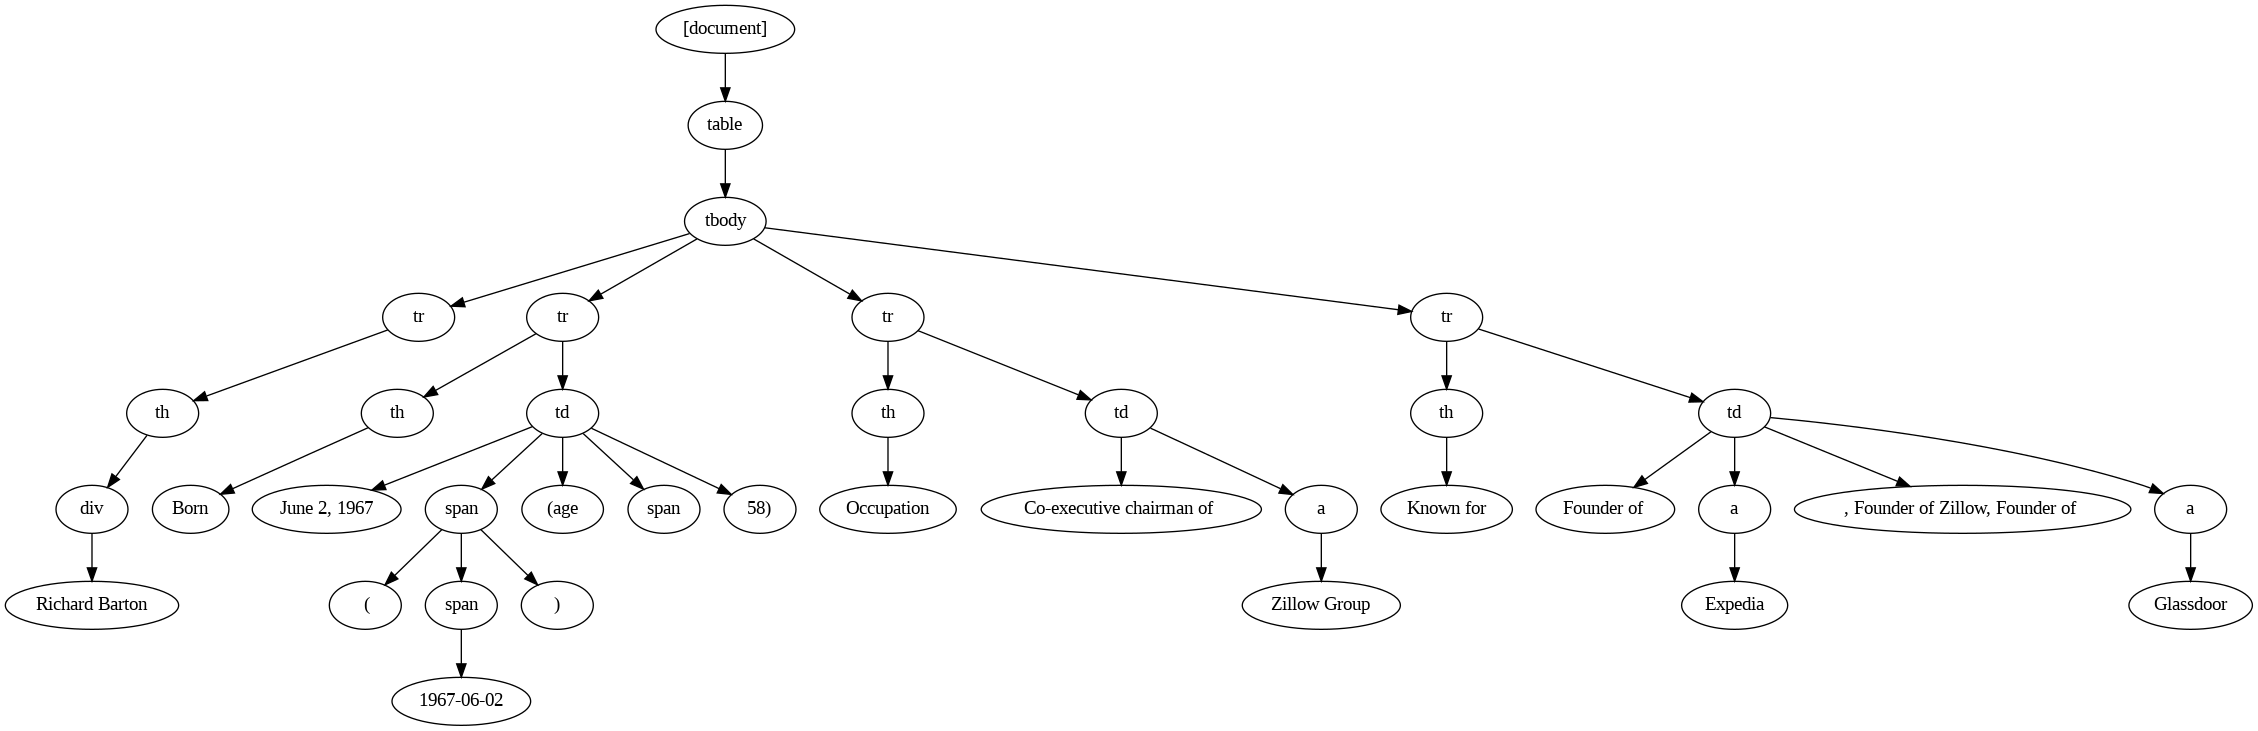

In [40]:
from lxml import etree

## Simple example

tree = etree.HTML(content)  #create a DOM tree of the page
example = tree.xpath('//table[contains(@class,"vcard")]')

# example is a list of nodes
# let's take the first element of the list (in our case there should only be one)
# and let's convert it back to a Unicode string using etree.tostring(...)

show_dom(etree.tostring(example[0], encoding='unicode'))

Now let's actually do our task! You can refer back to Section 1.4 for example code.

* Use `requests.get` to fetch https://en.wikipedia.org/wiki/List_of_women_CEOs_of_Fortune_500_companies, with `headers=headers`.

* Using **etree**, read, decode, and parse the page into a DOM tree called `tree`.



In [48]:
page = requests.get('').text # TODO

tree = etree.HTML(None) # TODO


Now Compute a list called `rows` with all rows (`tr`) within the single `table` in the DOM tree. Remember to use `//` and `/` appropriately. Beware that the table has a `tbody` between the `table` and `tr`.

In [ ]:
rows = tree.xpath('')# TODO

show_dom(etree.tostring(rows[1], encoding='unicode'))

Using XPath, compute, in the variable `oracle_ceo`, the DOM element for the *name* of the CEO of `Oracle` corporation.  You might want to look at https://en.wikipedia.org/wiki/List_of_women_CEOs_of_Fortune_500_companies in your browser and View source.

Hints:
* You can use `td[i]` to find the i-th column in a row, starting with i=1 as the first column
* You can use `[td//text()="abc"]` to filter to parent elements with text-content equal to "abc".

In [ ]:
oracle_ceo = tree.xpath('')# TODO

print(oracle_ceo)

# This will help you see what you got. A list of elements, a Unicode
# string, or a DOM tree
if len(oracle_ceo) > 1:
  print ('Multiple answers: {}'.format(oracle_ceo))
elif isinstance(oracle_ceo[0], etree._ElementUnicodeResult):
  print(str(oracle_ceo[0]))
else:
  show_dom(etree.tostring(oracle_ceo[0], encoding='unicode'))

In [58]:
# Once you actually get a person's name that you think is right, submit here.
grader.grade('ceo', answer=str(oracle_ceo[0]))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
